# SKHST

In [ ]:
!pip install stable_baselines3
!pip install gym

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import PIL.Image as image

import gym

from gym import Env, spaces
import time,os,random
font = cv2.FONT_HERSHEY_COMPLEX_SMALL

# The Point Class

In [ ]:
class Point(object):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        self.x = 0
        self.y = 0
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.name = name
        
    def clamp(self, n, min_n, max_n):
        return max(min(max_n,n), min_n)
    
    def set_position(self, x, y):
        self.x = self.clamp(x, self.x_min, self.x_max-self.icon_w)
        self.y = self.clamp(y, self.y_min, self.y_max-self.icon_h)
        
    def get_position(self):
        return (self.x, self.y)
    
    def move(self, del_x, del_y):
        self.x += del_x
        self.y += del_y
        self.set_position(self.x, self.y)

# The Elements class

In [ ]:
class Dino(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Dino, self).__init__(name, x_max, x_min, y_max, y_min)
        self.hopHeight = 50
        self.airTime = 20
        self.icon = cv2.imread("skhst_dino.png") / 225.0
        self.icon_w = 32
        self.icon_h = 32
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w))

class Cactus(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Cactus, self).__init__(name, x_max, x_min, y_max, y_min)
        self.isCrossed = False
        self.icon = cv2.imread("cactus.png") / 225.0
        self.icon_w = 32
        self.icon_h = 32
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w))


In [ ]:
'''
Rewarding constraints :-
 * For passing every frame : 1
 * For crossing a cactus : 10
 * For failing by hitting a cactus : -200
'''

class jurrasicLand(Env):
    def __init__(self):
        super(jurrasicLand, self).__init__()

        self.observation_shape = (300,800,3)
        self.observation_space = spaces.Box(low = np.zeros(self.observation_shape),
                                           high = np.ones(self.observation_shape),
                                           dtype = np.float16)
        self.action_space = spaces.Discrete(2,)
        self.canvas = np.ones(self.observation_shape)*1
        self.elements = []
        

        self.y_min = int(self.observation_shape[0]*0.1)
        self.x_min = 0
        self.y_max = int(self.observation_shape[0])
        self.x_max = self.observation_shape[1]

        
    def draw_elements_on_canvas(self):
        self.canvas = np.ones(self.observation_shape) * 1
        #Draw elements on canvas
        for elm in self.elements:
            elm_shape = elm.icon.shape
            x,y = elm.x, elm.y
            self.canvas[y : y+elm_shape[1],x : x+elm_shape[0]] = elm.icon
        score_card = "Distance covered : {} Successful Hops : {}".format(self.ep_return, self.successful_hops)
        self.canvas = cv2.putText(self.canvas, score_card, (10,20),
                                 font, 0.8, (0,0,0), 1, cv2.LINE_AA)       
           
    def reset(self):
        self.ep_return = 0
        self.cactus_count = 0
        
        self.on_air = False
        self.air_time = 0
        
        self.successful_hops = 0
        
        #initialise the dino     
        dino_x = 100
        dino_y = self.y_max # 60
        self.dino = Dino("dino", self.x_max, self.x_min, self.y_max, self.y_min)
        self.dino.set_position(dino_x,dino_y)
        
        self.elements = [self.dino]
        self.canvas = np.ones(self.observation_shape) * 1
        self.draw_elements_on_canvas()
        return self.canvas
    
    def render(self, mode= 'human'):
        assert mode in ['human','rgb_array'], "Invalid mode, must be either 'human' or 'rgb_array'!"
        if(mode=='human'):
            cv2.imshow("Dino Land",self.canvas)
            cv2.waitKey(10)
        elif(mode=='rgb_array'):
            return self.canvas
    
    def close(self):
        cv2.destroyAllWindows()
        
    def get_action_meaning(self):
        return {
            0 : 'Do Nothing',
            1 : 'Jump'
        }
    
    def has_collided(self, elm1, elm2):
        x_col = False
        y_col = False
        
        elm1_x, elm1_y = elm1.get_position()
        elm2_x, elm2_y = elm2.get_position()
        
        if 2*abs(elm1_x - elm2_x) <= (elm1.icon_w + elm2.icon_w):
            x_col = True
        if 2*abs(elm1_y - elm2_y) <= (elm1.icon_h + elm2.icon_h):
            y_col = True
        
        if(x_col and y_col):
            return True
        return False
    
    def has_crossed(self, elm1, elm2):
        elm1_x,elm1_y = elm1.get_position()
        elm2_x,elm2_y = elm2.get_position()
        
        if(elm1_x <= elm2_x):
            return True
        return False
    
    def are_they_collided(self, elm1, elm2):
        elm1_x, elm1_y = elm1.get_position()
        elm2_x, elm2_y = elm2.get_position()
        print(elm1_x,elm2_x)
        
        if(elm2_x>=elm1_x and elm2_x<=elm1_x+elm1.icon_w):
            x_col = True
        
    def step(self, action):
        done = False
        assert self.action_space.contains(action), "Invalid Action!"
        
        reward = 1
        
        if action == 0:
            self.dino.move(0,0)
        elif action == 1:
            if(not self.on_air):
                self.on_air = True
                self.dino.move(0,-self.dino.hopHeight)
            #self.dino.move(0,-5)
            else:
                self.dino.move(0,0)
            
       
        if self.on_air:
            if(self.air_time>=self.dino.airTime):
                self.on_air = False
                self.air_time = 0
                self.dino.move(0,self.dino.hopHeight)
            else:
                self.air_time +=1
                
        
                
        #spawn a cactus with pbt 0.01
        if random.random() < 0.01:
            
            spawned_cactus = Cactus("cactus_{}".format(self.cactus_count),
                                   self.x_max, self.x_min,
                                   self.y_max, self.y_min)
            self.cactus_count += 1
            cactus_x = self.x_max
            cactus_y = self.y_max
            spawned_cactus.set_position(cactus_x, cactus_y)
            self.elements.append(spawned_cactus)
            
        for elm in self.elements:
            if isinstance(elm, Cactus):
                if(elm.get_position()[0] <= self.x_min):
                    self.elements.remove(elm)
                else:
                    elm.move(-5,0)
                # Rewarding for successful hop, as if cactus' x_position is foun to be left of dino,
                # means that dino successfully hopped without making 'done = True'
                
                if((not elm.isCrossed) and self.has_crossed(elm,self.dino)):
                    self.successful_hops += 1
                    elm.isCrossed = True
                    reward += 10
                    #print("Rewarding..")
                if self.has_collided(self.dino, elm):
                    reward += -200
#                     episodic_return += reward
                    done = True
                    try:
                        self.elements.remove(self.dino)
                    except:
                        pass
        self.ep_return += reward
        self.draw_elements_on_canvas()
        return self.canvas, reward, done,{}
        

/opt/conda/lib/python3.8/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


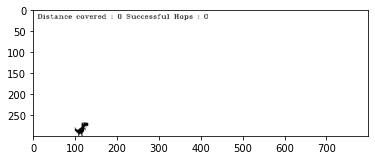

In [ ]:
env = jurrasicLand()
obs = env.reset()
plt.imshow(obs)

In [ ]:
# episodes = 5
# env = jurrasicLand()
# scores_l = []
# episodes_l = []
# hops_l = []
# for episode in range(1,episodes+1):
#     obs = env.reset()
#     done = False
#     score = 0
    
#     while not done:
#         env.render('human')
#         action = env.action_space.sample()
#         obs,reward,done,info = env.step(action)
#         score += reward
#     print('Episode:{} Score:{} Hops:{}'.format(episode,score,hops))
#     episodes_l.append(episode)
#     scores_l.append(score)
#     hops_l.append(hops)
# env.close()


In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

model = PPO("MlpPolicy",env,verbose=1)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
model.learn(total_timesteps=4000)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 288      |
|    ep_rew_mean     | 96.3     |
| time/              |          |
|    fps             | 64       |
|    iterations      | 1        |
|    time_elapsed    | 31       |
|    total_timesteps | 2048     |
---------------------------------


In [ ]:
model.save('model_4000')

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
avg_mean_ppo , std_dev_ppo = evaluate_policy(model,env,n_eval_episodes=10)

/opt/conda/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


In [ ]:
print('Average mean : {}\nAverage Std : {}'.format(avg_mean_ppo,std_dev_ppo))

Average mean : 64.2
Average Std : 130.0375330433487


In [ ]:
episodes = 200
scores_l = []
episodes_l = []
for episode in range(1,episodes+1):
    obs = env.reset()
    done = False
    score = 0
    
    while not done:
        # env.render('rgb_array')
        action, _states = model.predict(obs)
        obs,reward,done,info = env.step(action)
        score += reward
    print('Episode:{} Score:{}'.format(episode,score))
    episodes_l.append(episode)
    scores_l.append(score)
# env.close()


Episode:1 Score:-49
Episode:2 Score:177
Episode:3 Score:72
Episode:4 Score:-43
Episode:5 Score:-207
Episode:6 Score:30
Episode:7 Score:7
Episode:8 Score:166
Episode:9 Score:89
Episode:10 Score:-70
Episode:11 Score:44
Episode:12 Score:305
Episode:13 Score:84
Episode:14 Score:490
Episode:15 Score:669
Episode:16 Score:-68
Episode:17 Score:26
Episode:18 Score:281
Episode:19 Score:17
Episode:20 Score:35
Episode:21 Score:-37
Episode:22 Score:5
Episode:23 Score:214
Episode:24 Score:-68
Episode:25 Score:250
Episode:26 Score:-29
Episode:27 Score:473
Episode:28 Score:53
Episode:29 Score:224
Episode:30 Score:59
Episode:31 Score:19
Episode:32 Score:51
Episode:33 Score:105
Episode:34 Score:-22
Episode:35 Score:154
Episode:36 Score:114
Episode:37 Score:-17
Episode:38 Score:-39
Episode:39 Score:196
Episode:40 Score:55
Episode:41 Score:143
Episode:42 Score:24
Episode:43 Score:18
Episode:44 Score:138
Episode:45 Score:18
Episode:46 Score:378
Episode:47 Score:71
Episode:48 Score:0
Episode:49 Score:137
Ep

In [ ]:
from stable_baselines3 import A2C
from stable_baselines3.common.env_util import make_vec_env

model_a2c = A2C("MlpPolicy",env,verbose=1)
model_a2c.learn(total_timesteps=4000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 180      |
|    ep_rew_mean        | -20.5    |
| time/                 |          |
|    fps                | 31       |
|    iterations         | 100      |
|    time_elapsed       | 15       |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.531   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 1.48     |
|    value_loss         | 7.68     |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 179       |
|    ep_rew_mean        | -15       |
| time/                 |           |
|    fps                | 31        |
|    iterations         | 200       |
|    time_

In [ ]:
model_a2c.save('a2c_4000')

In [ ]:
episodes = 200
a2c_scores_l = []
a2c_episodes_l = []
for episode in range(1,episodes+1):
    obs = env.reset()
    done = False
    score = 0
    
    while not done:
        # env.render('rgb_array')
        action, _states = model_a2c.predict(obs)
        obs,reward,done,info = env.step(action)
        score += reward
    print('Episode:{} Score:{}'.format(episode,score))
    a2c_episodes_l.append(episode)
    a2c_scores_l.append(score)
# env.close()

Episode:1 Score:62
Episode:2 Score:314
Episode:3 Score:202
Episode:4 Score:95
Episode:5 Score:200
Episode:6 Score:147
Episode:7 Score:103
Episode:8 Score:63
Episode:9 Score:199
Episode:10 Score:42
Episode:11 Score:-9
Episode:12 Score:377
Episode:13 Score:474
Episode:14 Score:85
Episode:15 Score:-31
Episode:16 Score:20
Episode:17 Score:-22
Episode:18 Score:137
Episode:19 Score:911
Episode:20 Score:167
Episode:21 Score:42
Episode:22 Score:21
Episode:23 Score:-9
Episode:24 Score:22
Episode:25 Score:-52
Episode:26 Score:136
Episode:27 Score:73
Episode:28 Score:20
Episode:29 Score:240
Episode:30 Score:-20
Episode:31 Score:177
Episode:32 Score:-42
Episode:33 Score:11
Episode:34 Score:-42
Episode:35 Score:188
Episode:36 Score:51
Episode:37 Score:1
Episode:38 Score:30
Episode:39 Score:272
Episode:40 Score:308
Episode:41 Score:97
Episode:42 Score:10
Episode:43 Score:400
Episode:44 Score:-43
Episode:45 Score:380
Episode:46 Score:-22
Episode:47 Score:-9
Episode:48 Score:222
Episode:49 Score:107
E

In [ ]:
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env

model_dqn = DQN("MlpPolicy",env,verbose=1)
model_dqn.learn(total_timesteps=4000)
model_dqn.save('dqn_4000')

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/opt/conda/lib/python3.8/site-packages/stable_baselines3/common/buffers.py:220: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2880.02GB > 22.19GB
  warnings.warn(


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 304      |
|    ep_rew_mean      | 114      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 106      |
|    time_elapsed     | 11       |
|    total_timesteps  | 1216     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 251      |
|    ep_rew_mean      | 60.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 107      |
|    time_elapsed     | 18       |
|    total_timesteps  | 2011     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 250      |
|    ep_rew_mean      | 58       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

In [1]:
episodes = 200
dqn_scores_l = []
dqn_episodes_l = []
for episode in range(1,episodes+1):
    obs = env.reset()
    done = False
    score = 0
    
    while not done:
        # env.render('rgb_array')
        action, _states = model.predict(obs)
        obs,reward,done,info = env.step(action)
        score += reward
    print('Episode:{} Score:{}'.format(episode,score))
    episodes_l.append(episode)
    scores_l.append(score)
# env.close()

NameError: name 'env' is not defined

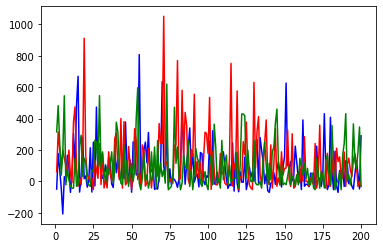

In [ ]:
from matplotlib import pyplot as plt
plt.plot(episodes_l,scores_l,color='blue')
plt.plot(a2c_episodes_l,a2c_scores_l,color='red')
plt.plot(dqn_episodes_l,dqn_scores_l,color='green')

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
avg_mean_ppo , std_dev_ppo = evaluate_policy(model,env,n_eval_episodes=10)
avg_mean_a2c , std_dev_a2c = evaluate_policy(model_a2c,env,n_eval_episodes=10)
avg_mean_dqn , std_dev_dqn = evaluate_policy(model_dqn,env,n_eval_episodes=10)

KeyboardInterrupt: 

In [ ]:
import statistics
s_avg_mean_ppo , s_std_dev_ppo = statistics.mean(scores_l), statistics.stdev(scores_l)
s_avg_mean_a2c , s_std_dev_a2c = statistics.mean(a2c_scores_l), statistics.stdev(a2c_scores_l)
s_avg_mean_dqn , s_std_dev_dqn = statistics.mean(dqn_scores_l), statistics.stdev(dqn_scores_l)

In [ ]:
from tabulate import tabulate

mydata = [
    ['Model', 'Mean', 'Stdev'],
      ['PPO', s_avg_mean_ppo, round(s_std_dev_ppo,2)],
      ['A2C', s_avg_mean_a2c, round(s_std_dev_a2c,2)],
      ['DQN', s_avg_mean_dqn, round(s_std_dev_dqn,2)]
]
 
# display table
print(tabulate(mydata))

-----  ------  ------
Model  Mean    Stdev
PPO    86.315  147.19
A2C    122.89  180.35
DQN    96.68   143.47
-----  ------  ------
